# Обучение сиамской сети для различия двух объектов

Обучение на данных MOT20Ext

In [70]:
import albumentations as A
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch import Generator, nn
from torch.optim import Adam, Optimizer
from torch.utils.data import ConcatDataset, DataLoader, random_split
from torchvision import models
from tqdm import tqdm

from src.config import (IMAGENET_MEAN, IMAGENET_STD, MOT20_EXT_FIRST_AXIS_MEAN,
                        MOT20_EXT_SECOND_AXIS_MEAN)
from src.data import MOT20ExtDataset
from src.models import ContrastiveLoss, SiameseBasicCNN
from src.train import display_batch, display_images, get_statistics
from src.transforms import get_norm_transform, get_resize_transform

## Загрузка данных

In [27]:
resize_transform = get_resize_transform((MOT20_EXT_FIRST_AXIS_MEAN, MOT20_EXT_SECOND_AXIS_MEAN)) 
norm_transform = get_norm_transform()
transform = A.Compose([resize_transform, norm_transform])

In [28]:
dataset01 = MOT20ExtDataset('data/MOT20_ext/train/MOT20-01/', transform=transform)
dataset02 = MOT20ExtDataset('data/MOT20_ext/train/MOT20-02/', transform=transform)
dataset03 = MOT20ExtDataset('data/MOT20_ext/train/MOT20-03/', transform=transform)
dataset05 = MOT20ExtDataset('data/MOT20_ext/train/MOT20-05/', transform=transform)

In [29]:
dataset = ConcatDataset([dataset01, dataset02, dataset03, dataset05])

In [30]:
len(dataset)

271442

### Создание даталоадеров

In [31]:
TEST_PROPROTION = 0.2
VAL_PROPORTION = 0.15
TRAIN_PROPORTION = 1 - TEST_PROPROTION - VAL_PROPORTION
sum([TEST_PROPROTION, VAL_PROPORTION, TRAIN_PROPORTION])

1.0

In [32]:
generator = torch.manual_seed(0)

In [33]:
train_set, val_set, test_set = random_split(
    dataset, [TRAIN_PROPORTION, VAL_PROPORTION, TEST_PROPROTION], generator=generator)

In [34]:
BATCH_SIZE = 64

In [35]:
train_loader = DataLoader(
    train_set,
    shuffle=True,
    batch_size=BATCH_SIZE,
    drop_last=True,
    generator=generator,
    
)

val_loader = DataLoader(
    val_set,
    shuffle=True,
    batch_size=BATCH_SIZE,
    drop_last=True,
    generator=generator
)

test_loader = DataLoader(
    test_set,
    shuffle=True,
    batch_size=BATCH_SIZE,
    drop_last=True,
    generator=generator
)

In [36]:
len(train_loader), len(val_loader), len(test_loader)

(2756, 636, 848)

### Расчет статистик

In [37]:
loader = DataLoader(
    dataset,
    shuffle=True,
    batch_size=BATCH_SIZE,
    drop_last=True,
    generator=generator,
)

In [38]:
# get_statistics(loader)

### Проверка отображения

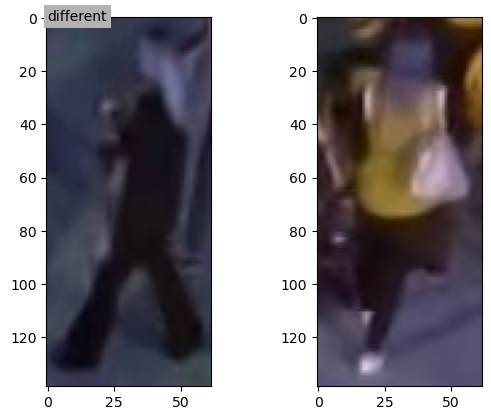

In [39]:
batch = next(iter(train_loader))
x1, x2, y = batch[0][0], batch[1][0], batch[2][0]
display_images((x1, x2), y)

In [40]:
# batch = next(iter(train_loader))
# display_batch(batch)

## Обучение

### DEBUG - Delete after

In [72]:
resnet = models.resnet18(pretrained=True)
resnet

/home/nick/reidentification/.conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/nick/reidentification/.conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [73]:
class SiameseBasicCNN(nn.Module):
    """Простейшая сиамская сверточная нейронная сеть"""

    def __init__(self) -> None:
        super(SiameseBasicCNN, self).__init__()
        self.resnet = resnet
        # разморозим последний слой
        for x in resnet.fc.parameters():
            x.requires_grad = False

    def forward_once(self, x):
        return self.resnet(x)

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)

        return output1, output2


class ContrastiveLoss(nn.Module):
    """Функция потерь для двух объектов. Вычисляет евклидово расстояние между объектами"""

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        # Calculate the euclidian distance and calculate the contrastive loss
        euclidean_distance = F.pairwise_distance(
            output1, output2, keepdim=True)

        loss_contrastive = torch.mean(
            (1-label) * torch.pow(euclidean_distance, 2) +
            (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))

        return loss_contrastive, euclidean_distance


### Обучение

In [61]:
def train(
    model: torch.nn.Module = None,
    train_loader: DataLoader = None,
    val_loader: DataLoader = None,
    optimizer: Optimizer = None,
    criterion = None,
    epoch_count: int = 10,
    scheduler: None = None,
    threshold: float = 0.5,
    device: torch.device = torch.device('cpu'),
):
    losses_train = []
    accuracies_train = []
    losses_val = []
    accuracies_val = []

    for epoch in range(epoch_count):
        for phase in ['train', 'val']:
            if (phase == 'train'):
                dataloader = train_loader
                if (scheduler is not None):
                    scheduler.step()
                model.train()
            else:
                dataloader = val_loader
                model.eval()

            running_loss = 0.
            running_acc = 0.
            # TODO: определить какая будет метрика качества

            for (x1, x2, y) in tqdm(train_loader):
                x1, x2, y = x1.to(device), x2.to(device), y.to(device)
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    predict1, predict2 = model(x1, x2)
                    loss, distance = criterion(predict1, predict2, y)
                    result = 1 if (distance < threshold) else 0
                    if (phase == 'train'):
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item()
                running_acc += 1 if (result - y == 0) else 0
            
            epoch_loss = running_loss / len(dataloader)
            epoch_acc = running_acc / len(dataloader)
            if phase == 'val':
                losses_val.append(epoch_loss)
                accuracies_val.append(epoch_acc)
            else:
                losses_train.append(epoch_loss)
                accuracies_train.append(epoch_acc)
    
    return model, {
        'train': (losses_train, accuracies_train),
        'val': (losses_val, accuracies_val)
    }

### Настройка параметров обучения

In [74]:
model = SiameseBasicCNN()
lr = 1e-3
criterion = ContrastiveLoss()
optimizer = Adam(model.parameters(), lr)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = train(
    model=model,
    criterion=criterion,
    device=device,
    train_loader=train_loader,
    val_loader=val_loader,
    epoch_count=10,
    optimizer=optimizer,
)

  0%|          | 0/2756 [00:00<?, ?it/s]


UnboundLocalError: local variable 'output' referenced before assignment